In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from tqdm.notebook import tqdm
sns.set(style="whitegrid")

In [2]:
# Define the path to the original dataset directory
original_dataset_dir = '/kaggle/input/redbloodcell/ALL_IDB2'  # Change this if needed

# Define a writable output directory for the new folders
output_dir = '/kaggle/working/leukemia-dataset-separated'  # Writable directory for new dataset
os.makedirs(output_dir, exist_ok=True)

# Define paths for the new class folders
healthy_dir = os.path.join(output_dir, 'healthy')
blast_dir = os.path.join(output_dir, 'blast')

# Create the new folders in the writable directory
os.makedirs(healthy_dir, exist_ok=True)
os.makedirs(blast_dir, exist_ok=True)

# Iterate over each file in the original dataset directory
for filename in os.listdir(original_dataset_dir):
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.tif'):
        # Check the last digit after the underscore to determine the label
        label = filename.split('_')[1][0]
        
        # Move file to the appropriate folder based on label
        source_path = os.path.join(original_dataset_dir, filename)
        if label == '0':
            shutil.copy(source_path, os.path.join(healthy_dir, filename))  # Copy to healthy folder
        elif label == '1':
            shutil.copy(source_path, os.path.join(blast_dir, filename))  # Copy to blast folder

print("Files have been separated into 'healthy' and 'blast' folders in the output directory.")

Files have been separated into 'healthy' and 'blast' folders in the output directory.


In [3]:
class ALLIDB2Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the directory with subdirectories for each class (healthy, blast).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        # Walk through each subdirectory and add file paths and labels
        for label, sub_dir in enumerate(['healthy', 'blast']):  # 0 for healthy, 1 for blast
            class_dir = os.path.join(root_dir, sub_dir)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_files.append(img_path)
                self.labels.append(label)  # Label based on folder name

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]
        
        # Load image and convert to RGB
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [6]:
from torchvision import transforms

# Define transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to the input size expected by ResNet50
    transforms.RandomHorizontalFlip(),       # Data augmentation
    transforms.RandomRotation(15),           # Rotate to add variety
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # More augmentation
    transforms.ToTensor(),                   # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   # Normalize based on ImageNet stats
])

# Define transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize to input size expected by ResNet50
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet stats
])

In [7]:
from torch.utils.data import DataLoader, random_split

# Root directory where 'healthy' and 'blast' folders are stored
dataset_root_dir = '/kaggle/working/leukemia-dataset-separated'

# Initialize the full dataset (no transform at this stage, as we will apply specific transforms per split)
full_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir)

# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.10 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

# Apply transformations to each dataset
train_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=train_transform)
val_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=val_test_transform)
test_dataset = ALLIDB2Dataset(root_dir=dataset_root_dir, transform=val_test_transform)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

Train size: 182, Val size: 26, Test size: 52


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import timm

In [52]:
class CondConv2D(nn.Module):
    """
    Conditionally Parameterized Convolutions as Branch Attention Mechanism.
    Multiple convolutional experts are combined dynamically based on input.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, num_experts=3):
        super(CondConv2D, self).__init__()
        self.num_experts = num_experts

        # Define multiple convolution experts (branches)
        self.expert_convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
            for _ in range(num_experts)
        ])
        
        # Gating mechanism to decide which expert should be applied more
        self.gate = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global context (pooling over spatial dimensions)
            nn.Flatten(),
            nn.Linear(in_channels, num_experts),  # Linear layer to output attention for each expert
            nn.Softmax(dim=1)  # Softmax to get probabilities (attention weights)
        )
    
    def forward(self, x):
        batch_size, _, _, _ = x.size()
        
        # Compute attention weights (gates) for each expert (branch)
        gates = self.gate(x)  # Shape: [batch_size, num_experts]
        
        # Apply each expert's convolution and compute weighted sum of the results
        out = sum(gates[:, i].view(batch_size, 1, 1, 1) * self.expert_convs[i](x)
                  for i in range(self.num_experts))
        
        return out

In [53]:
class GhostNet_CondConv(nn.Module):
    def __init__(self, num_classes):
        super(GhostNet_CondConv, self).__init__()
        # Initialize GhostNet without pre-trained weights
        self.base_model = timm.create_model('ghostnet_100', pretrained=False, num_classes=num_classes)
        self.features = self.base_model.forward_features  # Feature extraction part

        # Add CondConv2D after feature extraction
        self.cond_conv_block = CondConv2D(in_channels=960, out_channels=960, kernel_size=3, stride=1, padding=1, num_experts=3)  # CondConv block

        # Global average pooling and classifier
        self.pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.fc = nn.Linear(960, num_classes)  # Final classifier

    def forward(self, x):
        # Feature extraction
        features = self.features(x)

        # Apply CondConv2D block for dynamic feature extraction
        dynamic_features = self.cond_conv_block(features)

        # Global average pooling
        pooled_features = self.pool(dynamic_features)

        # Flatten and classify
        output = torch.flatten(pooled_features, 1)
        output = self.fc(output)

        return output


In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model for binary or multi-class classification
num_classes = 2 
model = GhostNet_CondConv(num_classes=num_classes)  # For RGB images

# Move the model to the GPU (or CPU if GPU is not available)
model.to(device)

# Check model architecture
print(model)

GhostNet_CondConv(
  (base_model): GhostNet(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): GhostBottleneck(
          (ghost1): GhostModule(
            (primary_conv): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (cheap_operation): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (ghost2): GhostModule(
            (p

In [55]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [56]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            # Calculate loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            # Record loss and accuracy
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save the model with the best validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Usage example
num_epochs = 25
model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)

Epoch 1/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 10.1697 Acc: 0.5192


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.7545 Acc: 0.5000

Epoch 2/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.8478 Acc: 0.6423


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6962 Acc: 0.5000

Epoch 3/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.8590 Acc: 0.5154


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.7078 Acc: 0.5000

Epoch 4/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 1.2425 Acc: 0.5962


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.3124 Acc: 0.5000

Epoch 5/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.7416 Acc: 0.5962


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.6355 Acc: 0.6000

Epoch 6/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.6965 Acc: 0.6538


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.5321 Acc: 0.7846

Epoch 7/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5707 Acc: 0.6885


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.5202 Acc: 0.7731

Epoch 8/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5259 Acc: 0.7385


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.4950 Acc: 0.7846

Epoch 9/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.5438 Acc: 0.7385


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.4173 Acc: 0.8231

Epoch 10/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4826 Acc: 0.7538


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2899 Acc: 0.8923

Epoch 11/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4184 Acc: 0.8115


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3093 Acc: 0.9154

Epoch 12/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4151 Acc: 0.8462


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3218 Acc: 0.9038

Epoch 13/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3711 Acc: 0.8423


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3115 Acc: 0.8923

Epoch 14/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3490 Acc: 0.8385


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2925 Acc: 0.8846

Epoch 15/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3755 Acc: 0.8500


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3294 Acc: 0.8731

Epoch 16/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3848 Acc: 0.8615


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3203 Acc: 0.8808

Epoch 17/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3746 Acc: 0.8269


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.3384 Acc: 0.8654

Epoch 18/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3887 Acc: 0.8308


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2939 Acc: 0.8962

Epoch 19/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3731 Acc: 0.8269


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2888 Acc: 0.8923

Epoch 20/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.4009 Acc: 0.8231


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2646 Acc: 0.9154

Epoch 21/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3604 Acc: 0.8538


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2740 Acc: 0.9154

Epoch 22/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3820 Acc: 0.8308


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2804 Acc: 0.9077

Epoch 23/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3550 Acc: 0.8500


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2754 Acc: 0.9192

Epoch 24/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3494 Acc: 0.8692


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2716 Acc: 0.9154

Epoch 25/25
----------


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3691 Acc: 0.8308


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 0.2820 Acc: 0.9077

Best Validation Acc: 0.9192


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.87      0.95      0.91       130
       Blast       0.95      0.86      0.90       130

    accuracy                           0.91       260
   macro avg       0.91      0.91      0.91       260
weighted avg       0.91      0.91      0.91       260



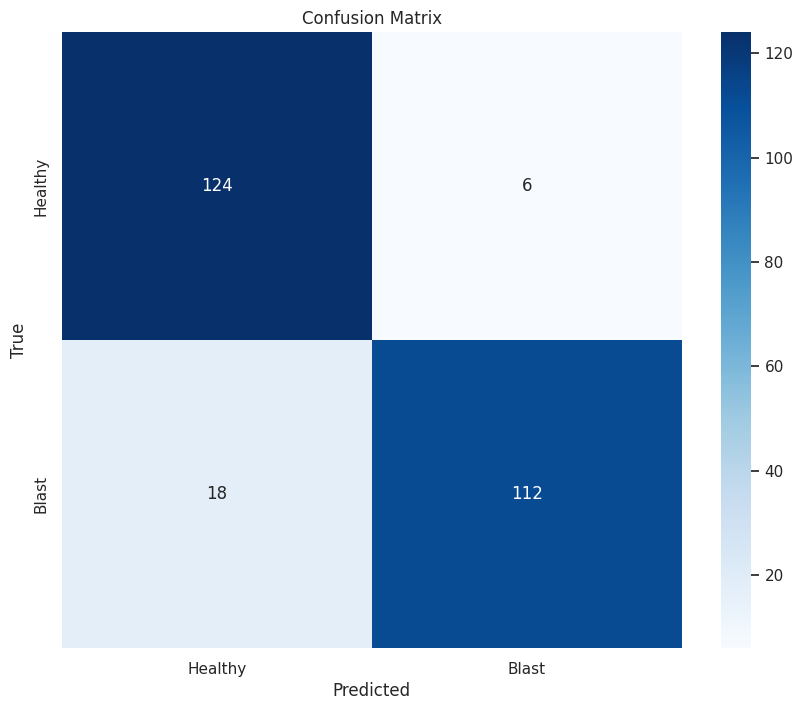

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
evaluate_model(model, test_loader, classes=['Healthy', 'Blast'])

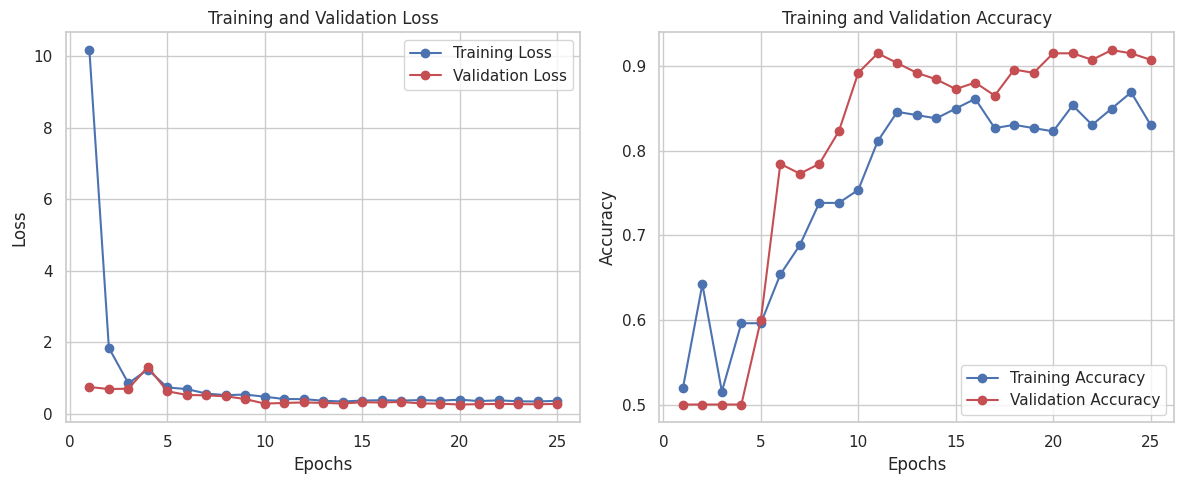

In [58]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)

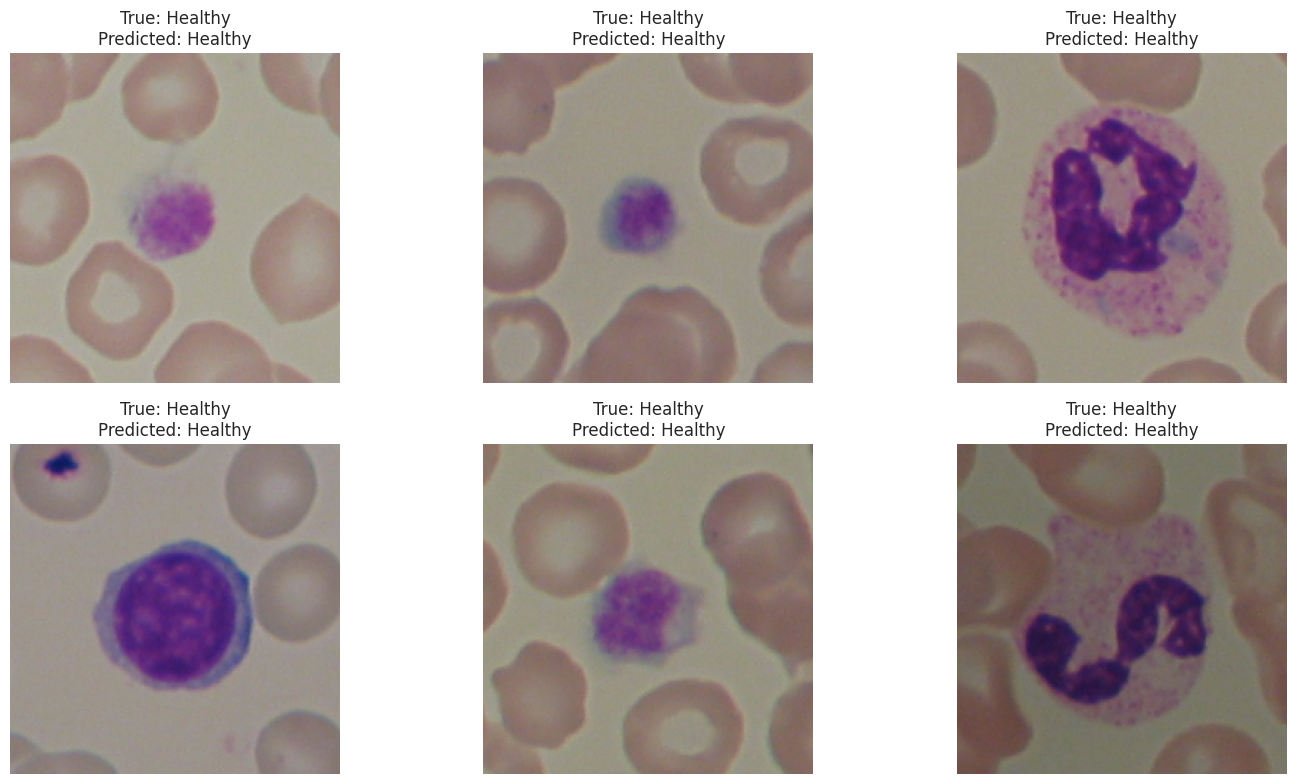

In [59]:
def visualize_predictions(model, dataloader, classes, num_images=6):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        # Display each image with true and predicted labels
        plt.subplot(2, num_images // 2, i + 1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)  # Un-normalize for visualization
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}\nPredicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(model, test_loader, classes=['Healthy', 'Blast'], num_images=6)